In [1]:
from psmc.model import PSMC
from psmc.plot import plot_history
from psmc.utils import process_psmcfa
import numpy as np 
import matplotlib.pyplot as plt
import re

### Read simulation data

In [2]:
def read_sim_history(s):
    pattern = r'-eN\s+([\d.]+)\s+([\d.]+)'
    matches = re.findall(pattern, s)
    tuples = [[float(match[0]), float(match[1])] for match in matches]
    # tuples = [[0, tuples[0][1]]] + tuples
    tuples = [[0, 1]] + tuples
    return np.array(tuples)

## Test run on simulated data

This example demonstrates a test run on 3% of a simulated genome, taking approximately 30 minutes to compute using an M1 Mac and 10 iterations of the Expectation-Maximization (EM) algorithm. Prior to running the inference, the "correct" simulated parameters are input into the model to visualize the relationship between historical effective population size and transition probabilities. Subsequently, inference is conducted on a new instance of the PSMC class.

### Brief overview of PSMC

PSMC (Pairwise Sequentially Markovian Coalescent) is a computational model that leverages coalescent theory to infer past population size dynamics by analyzing the genomic sequence heterozygosity. 

Over generations, our genetic material undergoes mutation and recombination processes. While mutations provide a means to estimate the time since divergence, recombination facilitates the exchange of genetic information between chromosome sets, preserving fragments of parental variation for future generations. Consequently, our chromosomes are composed of numerous fragments. When examined in conjunction with our diploid set, these fragments enable the tracing of our genetic heritage back to thousands of most recent common ancestors (MRCAs).Coalescent theory presents a direct relationship between the effective population size ($N_e$) at a given time and the probability of coalescence events: larger populations exhibit lower probabilities, while population bottlenecks result in an increased number of coalescence events (MRCAs) for the corresponding time period.

However, in practice, we are unable to pinpoint where crossover breakpoints occur. To address this, the authors developed a sequential hidden Markov model (HMM) that establishes a direct connection between population size history and genome sequence heterozygosity. The model's innovation lies in formulating the necessary mathematics to define this HMM, assuming a Markovian process. Although a strong assumption, the resulting model has proven to be both effective and useful.

Due to the extensive length of the genome sequence, calculating the probabilities of latent variables is computationally demanding. To make this process more manageable, the EM algorithm is employed. Rather than directly maximizing the likelihood, the EM algorithm optimizes a computationally efficient lower bound. This implementation of PSMC uses numpy (and a bit of numba) to approach the speed of the original C code.

In [3]:
with open('simulations/ms-commands.txt', 'r') as f:
    cmds = f.readlines()
    
sim_history = read_sim_history(cmds[0])

generated_seq = process_psmcfa('./simulations/sim-1.psmcfa.gz', batch_size=None)

xs = np.array(generated_seq) #simulated data stored here

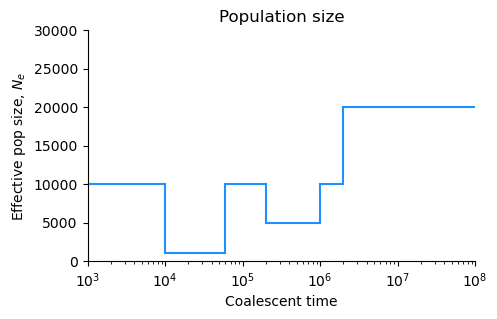

In [4]:
n0 = 1e4
theta = n0 * 4 * 2.5 * 1e-8
rho = 0.8 * theta

plt.figure(figsize=(5,3))

for i in range(sim_history.shape[0] - 1):
    plt.plot(sim_history[[i,i+1],0] * n0 * 4 * 25, sim_history[[i,i],1] * n0, c='dodgerblue')
    plt.plot(sim_history[[i+1,i+1],0] * n0 * 4 * 25, sim_history[[i,i+1],1] * n0 , c='dodgerblue')
plt.plot((sim_history[-1,0] * n0 * 4 * 25, 1e8 ), sim_history[[-1,-1],1] * n0, c='dodgerblue')

plt.gca().set_ylabel('Effective pop size, $N_e$')
plt.gca().set_xlabel('Coalescent time')
plt.gca().set_title('Population size')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_xscale('log')
plt.ylim(0, 3 * 1e4)
plt.xlim(1e3, 1e8);

In [5]:
n_steps = 64
psmc_model = PSMC(t_max=15, n_steps=n_steps, theta0=theta, rho0=rho, pattern='1*4+25*2+1*4+1*6')

generated_lam = []

c = 1
for i in range(n_steps + 1):
    if psmc_model.t[i] <= sim_history[c,0]:
        generated_lam.append(sim_history[c-1,1])
    elif psmc_model.t[i] > sim_history[c,0] and c < sim_history.shape[0] - 1:
        c += 1
        generated_lam.append(sim_history[c-1,1])
    else:
        generated_lam.append(sim_history[-1,1])

### Visualise model params with the parameters of the first simulation

Note the link between transition matrix and effective population size

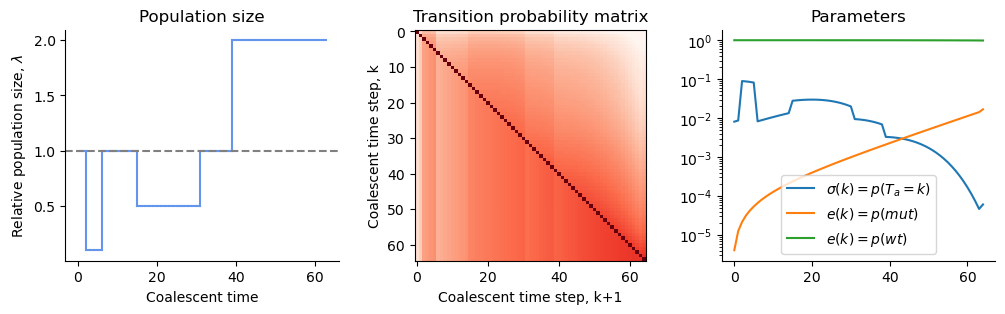

In [6]:
psmc_model = PSMC(t_max=15, n_steps=n_steps, theta0=theta , rho0=rho)
psmc_model.lam = np.array(generated_lam)
psmc_model.param_recalculate()

fig, axs = plt.subplots(1, 3, figsize=(4*3,3))

for i in range(psmc_model.n_steps-1):
    axs[0].plot(np.arange(psmc_model.n_steps)[[i,i+1]], psmc_model.lam[[i, i]], c='cornflowerblue')
    axs[0].plot(np.arange(psmc_model.n_steps)[[i+1,i+1]], psmc_model.lam[[i, i+1]], c='cornflowerblue')
# axs[0].set_xlim(1e4)
# plt.ylim(-2,2)
axs[0].axhline(1, c='grey', linestyle='--')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_ylabel('Relative population size, $\lambda$')
axs[0].set_xlabel('Coalescent time')
axs[0].set_title('Population size')
# axs[0].set_xscale('log')


m = psmc_model.transition_matrix()
axs[1].imshow(np.log(m), cmap='Reds', vmin=-20)
axs[1].set_title('Transition probability matrix')
axs[1].set_xlabel('Coalescent time step, k+1')
axs[1].set_ylabel('Coalescent time step, k')

axs[2].plot(psmc_model.sigma, label = r'$\sigma(k) = p(T_{a} = k)$')
axs[2].plot(psmc_model.emission_matrix()[1], label = r'$e(k) = p(mut)$')
axs[2].plot(psmc_model.emission_matrix()[0], label = r'$e(k) = p(wt)$')
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].set_yscale('log')
axs[2].set_title('Parameters')
axs[2].legend();

### Run EM 

In [7]:
# subset to only 90 Mb; note that input data is compressed using 100bp window
x = xs[:3,:]
x.shape

(3, 300000)

In [8]:
# initialise new instance and run EM

theta0 = np.sum(x) / (x.shape[0] * x.shape[1])
rho0 = theta0 / 5

psmc_model = PSMC(t_max=15, n_steps=64, pattern='1*4+25*2+1*4+1*6')
psmc_model.param_recalculate()

initial_params = [theta0, rho0, 15] + [1.] * (psmc_model.n_free_params - 3)
bounds = [(1e-4, 1e-1), (1e-5, 1e-1), (12, 20)] + [(0.1, 10)] * (psmc_model.n_free_params - 3)
loss_list, params_history = psmc_model.EM(initial_params, bounds, x=x, n_iter=10)

EM iteration 0
-110651.52547884212 --> -110273.71184102727 	Δ: -377.81363781484833
EM iteration 1
-110273.71184102727 --> -110167.63095757244 	Δ: -106.08088345482247
EM iteration 2
-110167.63095757244 --> -110131.66354380678 	Δ: -35.967413765669335
EM iteration 3
-110131.66354380678 --> -110118.13992190614 	Δ: -13.523621900632861
EM iteration 4
-110118.13992190614 --> -110112.31158927867 	Δ: -5.828332627468626
EM iteration 5
-110112.31158927867 --> -110109.7154644006 	Δ: -2.5961248780804453
EM iteration 6
-110109.7154644006 --> -110108.34090979742 	Δ: -1.3745546031714184
EM iteration 7
-110108.34090979742 --> -110107.45244550066 	Δ: -0.8884642967605032
EM iteration 8
-110107.45244550066 --> -110106.79740182517 	Δ: -0.6550436754914699
EM iteration 9
-110106.79740182517 --> -110106.2724715998 	Δ: -0.5249302253650967


In [9]:
#save model params
psmc_model.save_params('./checkpoints/test.json')

In [10]:
#load model params
psmc_model = PSMC()
psmc_model.load_params('./checkpoints/test.json')

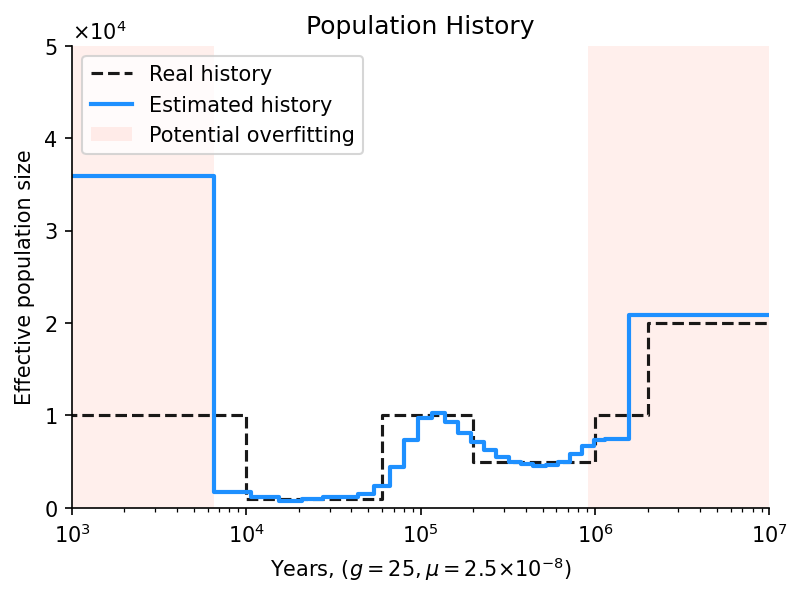

In [11]:
plot_history(psmc_model, x, sim_history, n0_sim=1e4, th=20)

This is not a perfect match, but pretty amazing given that it was trained on only 3% of the synthetic genome

## Inference on simulated data

The command `python run.py simulations/sim-1.psmcfa checkpoints/sim-1.json 15 --t_max 15 --n_steps 64 --pattern '1*4+25*2+1*4+1*6' --subset 10` was executed on 4 simulated datasets named sim-1, sim-2, sim-3, and sim-4, generated using the ms command as described in Li and Durbin, 2011.

The purpose of these simulations is to evaluate the performance of the PSMC model under different demographic scenarios. **sim-1** represents a population history similar to the PSMC estimate for non-African populations, **sim-2** assesses if the large recent population size is an intrinsic flaw of the PSMC model, **sim-3** evaluates the accuracy of the model given a sharp bottleneck, and **sim-4** checks if PSMC can recover the history estimated by itself.

The command generated comparable results for all 4 simulated datasets, despite only using 10% of the simulated genome. Here's the code used to generate the simulations:

```
ms 2 100 -t 30000 -r 6000 30000000 -eN 0.01 0.1 -eN 0.06 1 -eN 0.2 0.5 -eN 1 1 -eN 2 2 > sim-1.ms
ms 2 100 -t 3000 -r 600 30000000 -eN 0.1 5 -eN 0.6 20 -eN 2 5 -eN 10 10 -eN 20 5 > sim-2.ms
ms 2 100 -t 60000 -r 12000 30000000 -eN 0.01 0.05 -eN 0.0150 0.5 -eN 0.05 0.25 -eN 0.5 0.5 > sim-3.ms
ms 2 100 -t 65130.39 -r 10973.82 30000000 -eN 0.0055 0.0832 -eN 0.0089 0.0489 \
      -eN 0.0130 0.0607 -eN 0.0177 0.1072 -eN 0.0233 0.2093 -eN 0.0299 0.3630 \
      -eN 0.0375 0.5041 -eN 0.0465 0.5870 -eN 0.0571 0.6343 -eN 0.0695 0.6138 \
      -eN 0.0840 0.5292 -eN 0.1010 0.4409 -eN 0.1210 0.3749 -eN 0.1444 0.3313 \
      -eN 0.1718 0.3066 -eN 0.2040 0.2952 -eN 0.2418 0.2915 -eN 0.2860 0.2950 \
      -eN 0.3379 0.3103 -eN 0.3988 0.3458 -eN 0.4701 0.4109 -eN 0.5538 0.5048 \
      -eN 0.6520 0.5996 -eN 0.7671 0.6440 -eN 0.9020 0.6178 -eN 1.0603 0.5345 \
      -eN 1.4635 1.7931 > sim-4.ms
```

In [12]:
with open('simulations/ms-commands.txt', 'r') as f:
    cmds = f.readlines()

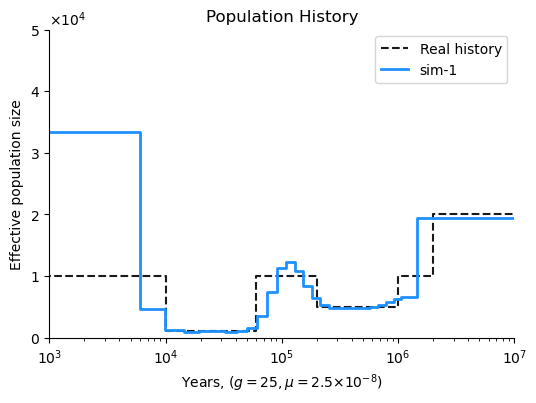

In [13]:
sim_history = read_sim_history(cmds[0])
fig, axs = plt.subplots(1,1,figsize=(6,4))
psmc = PSMC()
psmc.load_params('./checkpoints/sim-1.json')
plot_history(psmc, sim_history=sim_history, th=20,
             axs=axs, label='sim-1', color='dodgerblue')
# fig.savefig('./sim-1.pdf')

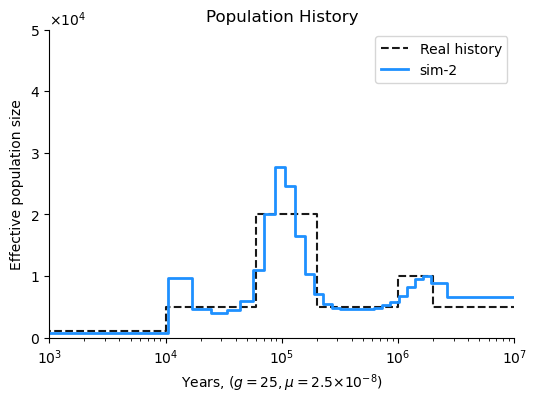

In [14]:
sim_history = read_sim_history(cmds[1])
fig, axs = plt.subplots(1,1,figsize=(6,4))
psmc = PSMC()
psmc.load_params('./checkpoints/sim-2.json')
plot_history(psmc, sim_history=sim_history, th=20,
             axs=axs, label='sim-2', n0_sim=1e3, color='dodgerblue')
# fig.savefig('./sim-2.pdf')

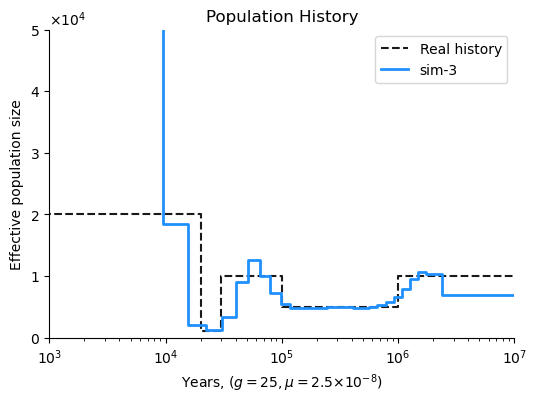

In [15]:
sim_history = read_sim_history(cmds[2])
fig, axs = plt.subplots(1,1,figsize=(6,4))
psmc.load_params('./checkpoints/sim-3.json')
plot_history(psmc, sim_history=sim_history, th=20,
             axs=axs, label='sim-3', n0_sim=2e4, color='dodgerblue')
# fig.savefig('./sim-3.pdf')

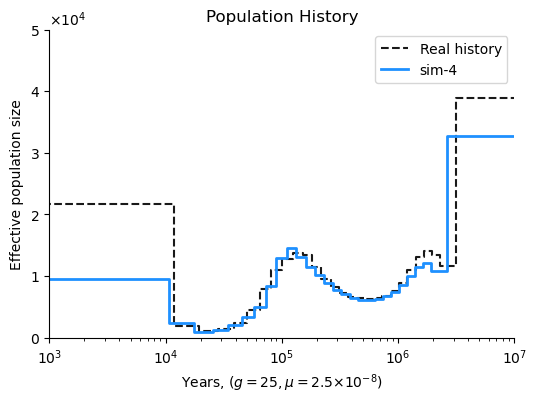

In [16]:
sim_history = read_sim_history(cmds[3])
fig, axs = plt.subplots(1,1,figsize=(6,4))
psmc = PSMC()
psmc.load_params('./checkpoints/sim-4.json')
plot_history(psmc, sim_history=sim_history, n0_sim=21710.3,
             th=20, axs=axs, label='sim-4', color='dodgerblue')
# fig.savefig('./sim-4.pdf')

## Inference on real genome data

I applied PSMC to chromosomes 1-5 for six individuals, representing diverse origins: three Africans (San, Mbuti, and Masai), a European (French), an East Asian (Japanese), and an Austronesian (Ami). The genome data was sourced from https://www.internationalgenome.org/.

The analysis reveals that all humans share a similar history until around 150,000 years ago, having endured a significant bottleneck approximately 1 million years ago. This bottleneck is not only evident in our DNA but is also supported by fossil records, with climate change potentially playing a role, among other factors. 

Around 150,000 years ago, the ancestral history of the selected individuals began to diverge. Interestingly, the major bottleneck experienced by all migrating populations was strikingly similar, regardless of the vast distances separating their descendants.

In contrast, the ancestors of African populations followed notably different trajectories, leading to a decline in effective population size that coincided with their relatives' migrations to Eurasia. The Toba supervolcanic eruption is one hypothesis proposed to explain this phenomenon.

When correlating inferred population sizes with archaeological data, it is tempting to speculate on causality – for example, did the utilization of fire or an increase in brain volume contribute to the recovery from the bottleneck 1 million years ago? However, as with any model, it is important to interpret $N_e$ with caution. Besides population size fluctuations, it could be influenced by 1) migration and gene flow 2) variable mutation rate 3) selection and others. 






(0.0, 25000.0)

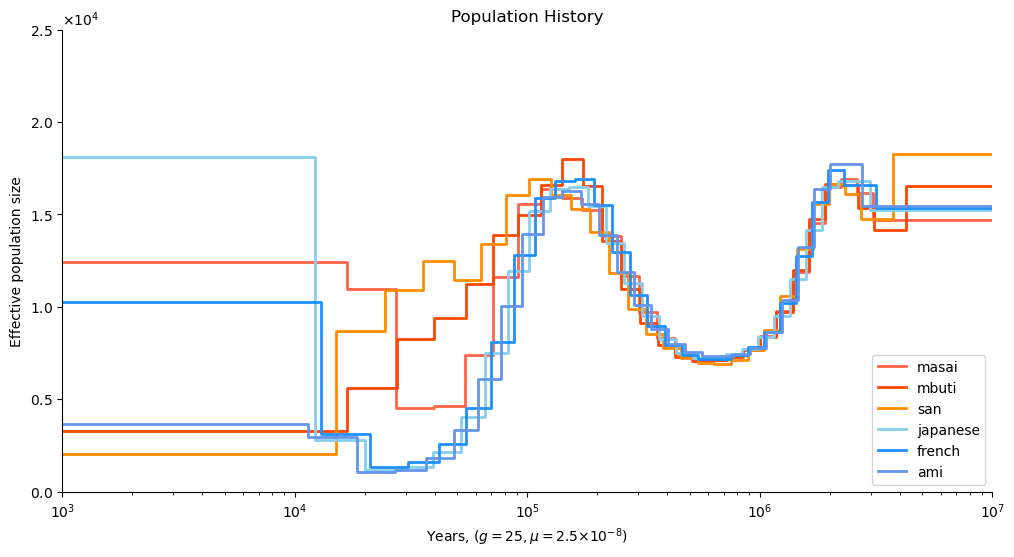

In [17]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
psmc = PSMC()
psmc.load_params('./checkpoints/masai_1-5.json')
plot_history(psmc, th=20, axs=axs, label='masai', color='tomato')
psmc.load_params('./checkpoints/mbuti_1-5.json')
plot_history(psmc, th=20, axs=axs, label='mbuti', color='orangered')
psmc.load_params('./checkpoints/san_1-5.json')
plot_history(psmc, th=20, axs=axs, label='san', color='darkorange')

psmc.load_params('./checkpoints/japanese_1-5.json')
plot_history(psmc, th=20, axs=axs, label='japanese', color='skyblue')
psmc.load_params('./checkpoints/french_1-5.json')
plot_history(psmc, th=20, axs=axs, label='french', color='dodgerblue')
psmc.load_params('./checkpoints/ami_1-5.json')
plot_history(psmc, th=20, axs=axs, label='ami', color='cornflowerblue')
axs.set_ylim(0,2.5e4)
# fig.savefig('./genomes_inferred.pdf')